In [1]:
import os
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader


import albumentations as A
from albumentations.pytorch import ToTensorV2

from torchvision.models.segmentation import deeplabv3_resnet50

/usr/local/lib/python3.12/dist-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error [Errno -3] Temporary failure in name resolution>
  data = fetch_version_info()


In [2]:
TRAIN_FORGED = "/kaggle/input/recodai-luc-scientific-image-forgery-detection/train_images/forged"
TRAIN_MASKS  = "/kaggle/input/recodai-luc-scientific-image-forgery-detection/train_masks"

TEST_IMAGES  = "/kaggle/input/recodai-luc-scientific-image-forgery-detection/test_images"

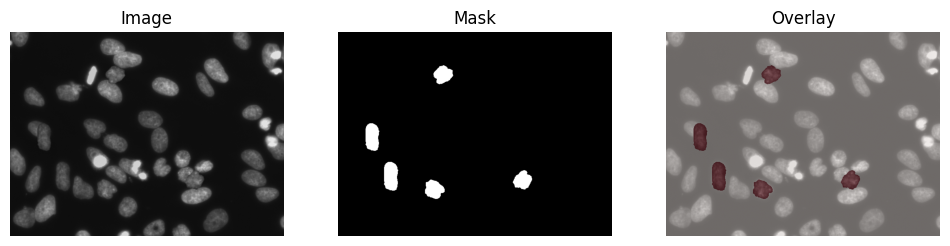

In [3]:
import matplotlib.pyplot as plt

img_name = os.listdir(TRAIN_FORGED)[0]

image = cv2.imread(os.path.join(TRAIN_FORGED, img_name))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

raw_mask = np.load(os.path.join(TRAIN_MASKS, img_name.replace(".png", ".npy")))
mask = (raw_mask.sum(axis=0) > 0).astype(np.uint8)

plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.title("Image")
plt.imshow(image)
plt.axis("off")

plt.subplot(1,3,2)
plt.title("Mask")
plt.imshow(mask, cmap="gray")
plt.axis("off")

plt.subplot(1,3,3)
plt.title("Overlay")
plt.imshow(image)
plt.imshow(mask, cmap="Reds", alpha=0.4)
plt.axis("off")

plt.show()

In [4]:
train_tfms = A.Compose([
    A.Resize(256, 256),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Normalize(),
    ToTensorV2()
])

In [5]:
class ForgeryDataset(Dataset):
    def __init__(self, img_dir, mask_dir=None, transform=None):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.images = sorted(os.listdir(img_dir))
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]

        image = cv2.imread(os.path.join(self.img_dir, img_name))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.mask_dir:
            raw_mask = np.load(
                os.path.join(self.mask_dir, img_name.replace(".png", ".npy"))
            )
            mask = (raw_mask.sum(axis=0) > 0).astype(np.float32)
        else:
            mask = np.zeros(image.shape[:2], dtype=np.float32)

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented["image"]
            mask = augmented["mask"].unsqueeze(0)

        return image, mask

In [6]:
ds = ForgeryDataset(TRAIN_FORGED, TRAIN_MASKS, train_tfms)
img, mask = ds[0]

print("Image:", img.shape)
print("Mask :", mask.shape)
print("Mask values:", torch.unique(mask))

Image: torch.Size([3, 256, 256])
Mask : torch.Size([1, 256, 256])
Mask values: tensor([0., 1.])


In [7]:
train_loader = DataLoader(
    ForgeryDataset(TRAIN_FORGED, TRAIN_MASKS, train_tfms),
    batch_size=8,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

In [8]:
def dice_loss(pred, target, smooth=1.0):
    pred = torch.sigmoid(pred)
    intersection = (pred * target).sum()
    return 1 - (2. * intersection + smooth) / (
        pred.sum() + target.sum() + smooth
    )

def combined_loss(pred, target):
    bce = nn.BCEWithLogitsLoss()(pred, target)
    dice = dice_loss(pred, target)
    return bce + dice

loss_fn = combined_loss

In [9]:
from torchvision.models.segmentation import deeplabv3_resnet50
import torch.nn as nn

model = deeplabv3_resnet50(
    weights=None,              # no Deeplab pretrained weights
    weights_backbone=None,     # no ResNet pretrained weights
    num_classes=1              # directly set output channels
)

device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)

In [10]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

In [11]:
EPOCHS = 10

for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0

    for imgs, masks in tqdm(train_loader):
        imgs, masks = imgs.to(device), masks.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)["out"]
        loss = loss_fn(outputs, masks)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{EPOCHS} - Avg Loss: {avg_loss:.4f}")

100%|██████████| 344/344 [02:15<00:00,  2.54it/s]


Epoch 1/10 - Avg Loss: 1.0858


100%|██████████| 344/344 [02:09<00:00,  2.66it/s]


Epoch 2/10 - Avg Loss: 0.8979


100%|██████████| 344/344 [02:09<00:00,  2.66it/s]


Epoch 3/10 - Avg Loss: 0.8444


100%|██████████| 344/344 [02:09<00:00,  2.66it/s]


Epoch 4/10 - Avg Loss: 0.8125


100%|██████████| 344/344 [02:09<00:00,  2.65it/s]


Epoch 5/10 - Avg Loss: 0.8056


100%|██████████| 344/344 [02:09<00:00,  2.66it/s]


Epoch 6/10 - Avg Loss: 0.7839


100%|██████████| 344/344 [02:09<00:00,  2.66it/s]


Epoch 7/10 - Avg Loss: 0.7704


100%|██████████| 344/344 [02:09<00:00,  2.65it/s]


Epoch 8/10 - Avg Loss: 0.7637


100%|██████████| 344/344 [02:08<00:00,  2.67it/s]


Epoch 9/10 - Avg Loss: 0.7542


100%|██████████| 344/344 [02:09<00:00,  2.66it/s]

Epoch 10/10 - Avg Loss: 0.7382


In [12]:
THRESH = 0.4
MIN_AREA = 100
AUTH_AREA = 150

print(THRESH, MIN_AREA, AUTH_AREA)

0.4 100 150


In [13]:
import cv2
import numpy as np

def post_process_mask(prob_mask, thresh, min_area):
    binary = (prob_mask > thresh).astype(np.uint8)

    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(
        binary, connectivity=8
    )

    clean_mask = np.zeros_like(binary)

    for i in range(1, num_labels):
        if stats[i, cv2.CC_STAT_AREA] >= min_area:
            clean_mask[labels == i] = 1

    return clean_mask

In [14]:
def predict_with_tta(model, image):
    preds = []

    for aug in [None, "h", "v"]:
        img = image.copy()

        if aug == "h":
            img = np.fliplr(img)
        elif aug == "v":
            img = np.flipud(img)

        augmented = test_tfms(image=img)
        inp = augmented["image"].unsqueeze(0).to(device)

        pred = torch.sigmoid(model(inp)["out"]).cpu().numpy()[0, 0]

        if aug == "h":
            pred = np.fliplr(pred)
        elif aug == "v":
            pred = np.flipud(pred)

        preds.append(pred)

    return np.mean(preds, axis=0)


In [15]:
def rle_encode(mask):
    pixels = mask.flatten(order='F')
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return " ".join(str(x) for x in runs)

In [16]:
test_tfms = A.Compose([
    A.Resize(256, 256),
    A.Normalize(),
    ToTensorV2()
])

In [17]:
sample_sub = pd.read_csv(
    "/kaggle/input/recodai-luc-scientific-image-forgery-detection/sample_submission.csv"
)
sample_sub

,case_id,annotation
0,45,authentic


In [18]:
model.eval()

with torch.no_grad():
    # There is only ONE test image in this competition
    img_name = sorted(os.listdir(TEST_IMAGES))[0]

    image = cv2.imread(os.path.join(TEST_IMAGES, img_name))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    prob = predict_with_tta(model, image)

    mask = post_process_mask(
        prob,
        thresh=THRESH,
        min_area=MIN_AREA
    )

    if mask.sum() < AUTH_AREA:
        annotation = "authentic"
    else:
        rle = rle_encode(mask)
        annotation = rle if rle.strip() != "" else "authentic"

In [19]:
sample_sub["annotation"] = annotation
sample_sub

,case_id,annotation
0,45,14428 2 14684 2 14940 2 15196 3 15451 4 15564 ...


In [20]:
sample_sub.to_csv("submission.csv", index=False)
print("Saved submission.csv")

Saved submission.csv


In [21]:
print(sample_sub.dtypes)

case_id        int64
annotation    object
dtype: object
